# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [8]:
"""
Using 'w8a.csv' as training data and 'w8a_t.csv' as testing data.
"""

from sklearn import model_selection

w8a_train = pd.read_csv("w8a/w8a.csv", sep=";")
w8a_test = pd.read_csv("w8a/w8a_t.csv", sep=";")

w8a_train_x = w8a_train.iloc[:, :-1].values
w8a_train_y = w8a_train.iloc[:, -1].values
w8a_train_y[w8a_train_y == 0] = -1

w8a_test_x = w8a_test.iloc[:, :-1].values
w8a_test_y = w8a_test.iloc[:, -1].values
w8a_test_y[w8a_test_y == 0] = -1

In [9]:
w8a_train.shape, w8a_test.shape

((49748, 301), (14950, 301))

In [10]:
print('Train Set: ',np.unique(w8a_train.iloc[:,-1].values, return_counts=True))
print('Test Set: ',np.unique(w8a_test.iloc[:,-1].values, return_counts=True))

Train Set:  (array([-1,  1]), array([48269,  1479]))
Test Set:  (array([-1,  1]), array([14496,   454]))


In [11]:
train_count = np.unique(w8a_train.iloc[:,-1].values, return_counts=True)
test_count = np.unique(w8a_test.iloc[:,-1].values, return_counts=True)
print(train_count[1][1]/np.sum(train_count[1]))
print(test_count[1][1]/np.sum(test_count[1]))

0.029729838385462733
0.03036789297658863


## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="l2", solver="lbfgs", C=2) 
model.fit(w8a_train_x, w8a_train_y)
y_pred = model.predict(w8a_test_x)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


and we compute the accuracy score to evaluate the model performance:

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(w8a_test_y, y_pred)

0.9866220735785953

In [14]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([14640,   310]))

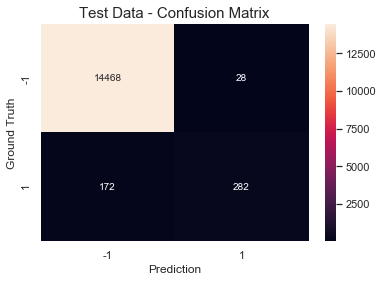

In [15]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,4))
plt.title('Test Data - Confusion Matrix',fontsize=15)
sns.heatmap(confusion_matrix(w8a_test_y,y_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

First, let us compute the gradient of the logistic regression:

Note: 
$$ l_{i}(w) = log(1+exp(-y_{i}w^{T}x_{i})) $$
Then:
$$ \frac{\partial l_{i}}{\partial w_{j}}(w) = \frac{\partial}{\partial w_{j}}(log(1+exp(-y_{i}w_{j}x_{i}^{(j)})))(w)  $$
$$ \Longrightarrow \frac{\partial l_{i}}{\partial w_{j}}(w) = \frac{-y_{i}x_{i}^{(j)}}{1+exp(y_{i}w_{j}x_{i}^{(j)})} $$
From which we can easily derive $\nabla L$.

In [16]:
import math
import random

In [179]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    gradient_history_: list
        the list of all gradients in visited batches and betas
    st_: float
        speed
    mt_: np.array
        position
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []
        self.gradient_history_ = []
        self.st_ = None
        self.mt_ = None

    def logistic(self, z):
        # logistic function
        return 1 / (1 + np.exp(-z))
    
    
    def compute_gradient(self, X_batch, y_batch):
        """
        Generates mini-batch and computes gradient.
        Args:
        X: (num_samples, num_features+1) np.array
            Design matrix
        y: (num_samples,) np.array
            Output vector
        """
        yX = np.matmul(np.diag(y_batch),X_batch)
        yy_hat = np.matmul(yX,np.diag(self.coef_))
        logis = self.logistic(-yy_hat)
        dli_dwj = - yX * logis
        gradient = np.mean(dli_dwj, axis=0)
        # Add gradient to history
        self.gradient_history_.append(gradient)
        

    def update_coef(self, iter_, method='ADAM', eps=1e-8, gamma=.9, beta=.999):
        """
        Updates coefficients given input acceleration method.
        Args:
        method: string
            Gradient Descent acceleration method. Must take values in ['Vanilla','Adagrad','RMSprop','Momentum',
            'ADAM'].
        eps: float
            Small epsilon used to ensure non-vanishing learning rate
        gamma, beta: float
            Hyper-parameters used in RMSprop, Momentum and ADAM gradient descent
        """
        if method == 'Vanilla':
            # Vanilla gradient descent
            self.st_ = 1.
            self.mt_ = self.gradient_history_[-1]
            
        elif method == 'Adagrad':
            # Adagrad gradient descent
            if self.st_ is None:
                self.st_ = 1.
            else:
                self.st_ = self.st_ + np.linalg.norm(self.gradient_history_[-1])**2
            self.mt_ = self.gradient_history_[-1]
            
        elif method == 'RMSprop':
            if self.st_ is None:
                self.st_ = 1.
            else:
                self.st_ = gamma * self.st_ + (1-gamma) * np.linalg.norm(self.gradient_history_[-1]) ** 2
            self.mt_ = self.gradient_history_[-1]
            
        elif method == 'Momentum':
            self.st_ = 1.
            if self.mt_ is None:
                self.mt_ = self.gradient_history_[-1]
            else:
                self.mt_ = beta * self.mt_ + self.gradient_history_[-1]
            
        elif method == 'ADAM':
            if self.st_ is None:
                self.st_ = 1.
                self.mt_ = self.gradient_history_[-1]
            else:
                self.st_ = gamma * self.st_ + (1-gamma) * np.linalg.norm(self.gradient_history_[-1])**2
                self.mt_ = beta * self.mt_ + (1-beta) * self.gradient_history_[-1]
            
        else:
            # Raise error because of wrong input acceleration method
            raise ValueError("Acceleration method must be included in ['Vanilla','Adagrad','RMSprop','Momentum','ADAM'].")
            
        # Update coefficients
        self.coef_ = self.coef_ - self.lr_ * (self.mt_ + self.alpha_ * self.coef_ / self.bsize_) / math.sqrt(self.st_ + eps)
        self.coef_history_.append(self.coef_)
        
        
    def fit(self, X, y, lr=1e-3, bsize=100, max_iter=100, method='ADAM', eps=1e-8, gamma=.9, beta=.999, patience=100, random_state=12345, plot=True):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        patience: integer
            If model does not improve for patience iterations, training is stopped
        eps: float
            Small epsilon used to ensure non-vanishing learning rate
        gamma, beta: float
            Hyper-parameters for accelerated gradient descent methods
        random_state: integer
            seed for random generation
        
        Note:
        -----
        Updates self.coef_
        """
        # Initialize input attributes
        self.lr_ = lr
        self.bsize_ = bsize
        
        # Initialize random generator
        rng = np.random.default_rng(random_state)
        
        # Add column of ones to data
        X_aug = np.c_[np.ones((X.shape[0],)),X]
        
        # Initialize coefficients randomly between 0 and 1
        self.coef_ = rng.random(X_aug.shape[1],)
        self.coef_history_.append(self.coef_)
        
        # batches will be used to generate random mini-batches
        batches = np.arange(X_aug.shape[0])
        iter_ = 0
        
        def f_lr():
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
            y_hat = np.matmul(X_aug, self.coef_.T)
            z = y * y_hat
            logis = self.logistic(z)
            log = - np.log(logis)
            loss = np.mean(log)
            return loss + self.alpha_ * np.linalg.norm(self.coef_) ** 2 / (2*X_aug.shape[0])
        
        # Convergence is met if model doesn't improve during patience iterations
        converge = False
        best_ = 0
        
        loss = f_lr()
        self.f_history_.append(loss)
        
        # Loop until convergence
        while not converge and iter_ <= max_iter:
            # Increment iteration
            iter_ += 1
            
            # Generate random batches
            rng.shuffle(batches)
            
            for start in range(0,batches.shape[0],self.bsize_):
                # Create mini-batch
                batch = batches[start:start+self.bsize_]
                X_batch, y_batch = X_aug[start:start+self.bsize_,:], y[start:start+self.bsize_]
                
                # Compute gradient over batch
                self.compute_gradient(X_batch, y_batch)
                
                # Update coefficients with regards to method
                self.update_coef(iter_, method=method, eps=eps, gamma=gamma, beta=beta)
                
            # Compute loss
            loss = f_lr()
            self.f_history_.append(loss)
            
            if loss <= min(self.f_history_):
                best_ = iter_
            elif iter_ - best_ + 1 >= patience:
                converge = True
                
        if plot:
            plt.plot(self.f_history_)
            plt.title('Training Loss, Best={} at Iteration: {}'.format(round(self.f_history_[best_],2) ,best_+1))
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (-1 or 1)
        """
        X_aug = np.c_[np.ones((X.shape[0],)),X]
        prod_pred = np.matmul(X_aug,self.coef_.T)
        # Negative values take label -1, positives take value 1
        prod_pred[prod_pred >= 0] = 1
        prod_pred[prod_pred < 0] = -1
        
        return prod_pred

Apply to data

Implement three acceleration methods and compare the results

In [180]:
X_train,y_train = w8a_train_x, w8a_train_y
X_test,y_test = w8a_test_x, w8a_test_y

In [181]:
alpha = .01

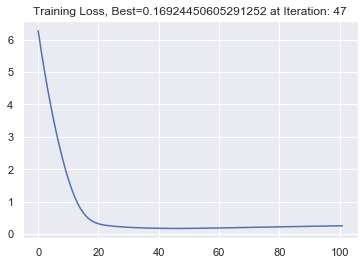

In [164]:
vanilla = StochasticLogisticRegression(alpha)
vanilla.fit(X_train,y_train,max_iter=100,bsize=100,method='Vanilla')

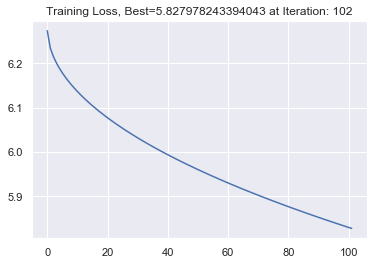

In [165]:
adagrad = StochasticLogisticRegression(alpha)
adagrad.fit(X_train,y_train,max_iter=100,bsize=100,method='Adagrad')

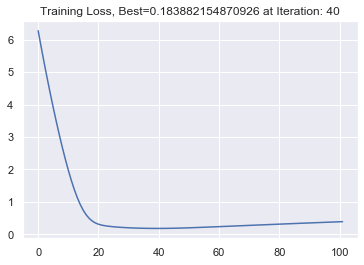

In [166]:
rmsprop = StochasticLogisticRegression(alpha)
rmsprop.fit(X_train,y_train,max_iter=100,bsize=100,method='RMSprop')

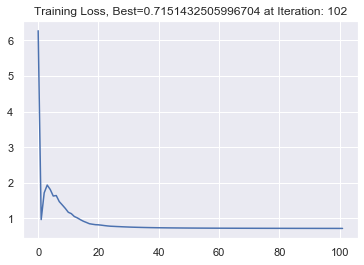

In [167]:
momentum = StochasticLogisticRegression(alpha)
momentum.fit(X_train,y_train,max_iter=100,bsize=100,method='Momentum')

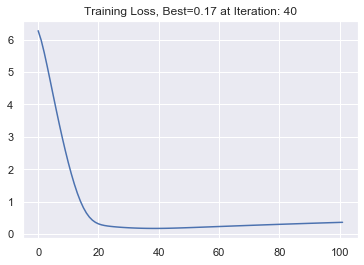

In [182]:
adam = StochasticLogisticRegression(alpha)
adam.fit(X_train,y_train,max_iter=100,bsize=100,method='ADAM')

In [169]:
vanilla_pred = vanilla.predict(X_test)
adagrad_pred = adagrad.predict(X_test)
rmsprop_pred = rmsprop.predict(X_test)
momentum_pred = momentum.predict(X_test)
adam_pred = adam.predict(X_test)

In [170]:
print('Vanilla accuracy: ',accuracy_score(w8a_test_y,vanilla_pred))
print('Adagrad accuracy: ',accuracy_score(w8a_test_y,adagrad_pred))
print('RMSProp accuracy: ',accuracy_score(w8a_test_y,rmsprop_pred))
print('Momentum accuracy: ',accuracy_score(w8a_test_y,momentum_pred))
print('ADAM accuracy: ',accuracy_score(w8a_test_y,adam_pred))

Vanilla accuracy:  0.03036789297658863
Adagrad accuracy:  0.03036789297658863
RMSProp accuracy:  0.03036789297658863
Momentum accuracy:  0.3725752508361204
ADAM accuracy:  0.03036789297658863


##### First Remarks:
Adagrad doesn't seem to work correctly. At least it learns much slower than the other tested methods. Let us compare learning curves from Vanilla, RMS-Prop, Momentum and ADAM methods.

### Method Comparison

In [100]:
X_train,y_train = w8a_train_x, w8a_train_y
X_test,y_test = w8a_test_x, w8a_test_y

In [101]:
alpha = .01

In [102]:
vanilla = StochasticLogisticRegression(alpha)
rmsprop = StochasticLogisticRegression(alpha)
momentum = StochasticLogisticRegression(alpha)
adam = StochasticLogisticRegression(alpha)

In [103]:
vanilla.fit(X_train,y_train,max_iter=100,bsize=100,method='Vanilla',plot=False)
print('Vanilla trained.')
rmsprop.fit(X_train,y_train,max_iter=100,bsize=100,method='RMSprop',plot=False)
print('RMSProp trained.')
momentum.fit(X_train,y_train,max_iter=100,bsize=100,method='Momentum',plot=False)
print('Momentum trained.')
adam.fit(X_train,y_train,max_iter=100,bsize=100,method='ADAM',plot=False)
print('ADAM trained.')

Vanilla trained.
RMSProp trained.
Momentum trained.
ADAM trained.


In [106]:
vanilla_f_ = np.log(vanilla.f_history_)
rmsprop_f_ = np.log(rmsprop.f_history_)
momentum_f_ = np.log(momentum.f_history_)
adam_f_ = np.log(adam.f_history_)

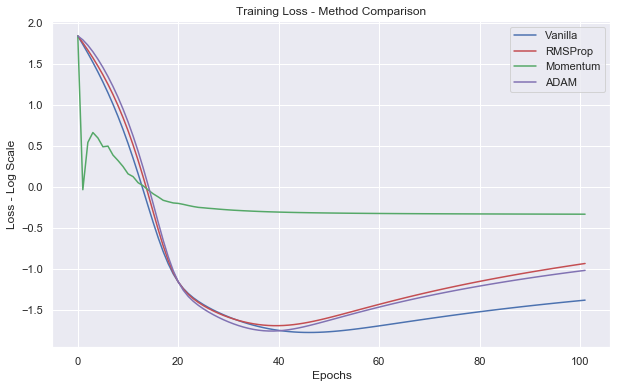

In [114]:
plt.figure(figsize=(10,6))
plt.plot(vanilla_f_, color='b', label='Vanilla')
plt.plot(rmsprop_f_, color='r', label='RMSProp')
plt.plot(momentum_f_, color='g', label='Momentum')
plt.plot(adam_f_, color='m', label='ADAM')
plt.legend(loc='upper right')
plt.title('Training Loss - Method Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss - Log Scale')
plt.show()

In [117]:
# Computing models' best epoch
vanilla_best = vanilla.f_history_.index(min(vanilla.f_history_))
rmsprop_best = rmsprop.f_history_.index(min(rmsprop.f_history_))
momentum_best = momentum.f_history_.index(min(momentum.f_history_))
adam_best = adam.f_history_.index(min(adam.f_history_))

In [120]:
print('Best Epoch - Vanilla: ', vanilla_best)
print('Best Epoch - RMSProp: ', rmsprop_best)
print('Best Epoch - Momentum: ', momentum_best)
print('Best Epoch - ADAM: ', adam_best)

Best Epoch - Vanilla:  46
Best Epoch - RMSProp:  39
Best Epoch - Momentum:  101
Best Epoch - ADAM:  39


As expected, RMSProp and ADAM offer faster learning than Vanilla. More unexpected though, Momentum is still learning after 100 epochs, therefore has a much longer learning process.

In [118]:
vanilla_pred = vanilla.predict(X_test)
rmsprop_pred = rmsprop.predict(X_test)
momentum_pred = momentum.predict(X_test)
adam_pred = adam.predict(X_test)

In [119]:
print('Vanilla accuracy: ',accuracy_score(w8a_test_y,vanilla_pred))
print('RMSProp accuracy: ',accuracy_score(w8a_test_y,rmsprop_pred))
print('Momentum accuracy: ',accuracy_score(w8a_test_y,momentum_pred))
print('ADAM accuracy: ',accuracy_score(w8a_test_y,adam_pred))

Vanilla accuracy:  0.9707023411371237
RMSProp accuracy:  0.9696989966555184
Momentum accuracy:  0.9711036789297659
ADAM accuracy:  0.9697658862876254


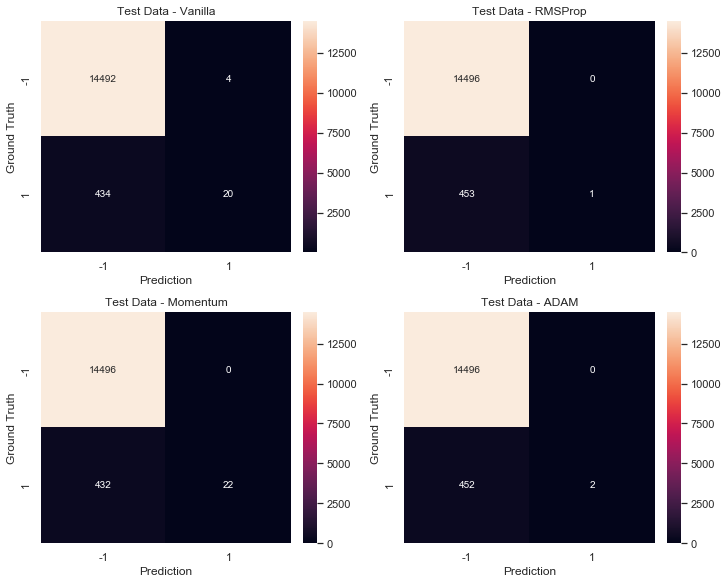

In [133]:
fig,axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), constrained_layout=True)

axs[0,0].set_title('Test Data - Vanilla')
sns.heatmap(confusion_matrix(w8a_test_y,vanilla_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1], ax=axs[0,0])
axs[0,0].set_xlabel('Prediction')
axs[0,0].set_ylabel('Ground Truth')

axs[0,1].set_title('Test Data - RMSProp')
axs[0,1] = sns.heatmap(confusion_matrix(w8a_test_y,rmsprop_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1], ax=axs[0,1])
axs[0,1].set_xlabel('Prediction')
axs[0,1].set_ylabel('Ground Truth')

axs[1,0].set_title('Test Data - Momentum')
axs[1,0] = sns.heatmap(confusion_matrix(w8a_test_y,momentum_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1], ax=axs[1,0])
axs[1,0].set_xlabel('Prediction')
axs[1,0].set_ylabel('Ground Truth')

axs[1,1].set_title('Test Data - ADAM')
axs[1,1] = sns.heatmap(confusion_matrix(w8a_test_y,adam_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1], ax=axs[1,1])
axs[1,1].set_xlabel('Prediction')
axs[1,1].set_ylabel('Ground Truth')

plt.show()

Quite surprisingly, Momentum offers the best accuracy, though its loss is the worst.

## Parameter Tuning

In this section, we attempt to tune the ADAM method. Note that this process should be done using a validation/tune set. \
Moreover, grid-search should be applied to tune parameters altogether. Because of time constraints, we decide to tune parameters independently.

#### Learning Rate

In [209]:
lr_vals = [1e-2,1e-3,1e-4]

In [212]:
# Model training
models = []

for lr in lr_vals:
    model = StochasticLogisticRegression(.01)
    model.fit(X_train,y_train,lr=lr,method='ADAM',plot=False)
    models.append(model)
    print('Model trained for lr value: {}'.format(lr))

Model trained for lr value: 0.01
Model trained for lr value: 0.001
Model trained for lr value: 0.0001


In [213]:
# Comparing Accuracies
for i in range(len(lr_vals)):
    lr = lr_vals[i]
    model = models[i]
    pred = model.predict(X_test)
    print("Accuracy Score - Learning Rate={}: {}".format(lr,accuracy_score(y_test,pred)))

Accuracy Score - Learning Rate=0.01: 0.9696321070234114
Accuracy Score - Learning Rate=0.001: 0.9697658862876254
Accuracy Score - Learning Rate=0.0001: 0.4189297658862876


Results are best for lr=0.001.

In [214]:
best_lr = 1e-3

#### Alpha

In [215]:
alpha_vals = [1., .1, .01, .001]

In [216]:
# Model training
models = []

for alpha in alpha_vals:
    model = StochasticLogisticRegression(alpha)
    model.fit(X_train,y_train,lr=best_lr,method='ADAM',plot=False)
    models.append(model)
    print('Model trained for alpha value: {}'.format(alpha))

Model trained for alpha value: 1.0
Model trained for alpha value: 0.1
Model trained for alpha value: 0.01
Model trained for alpha value: 0.001


In [217]:
# Comparing Accuracies
for i in range(len(alpha_vals)):
    alpha = alpha_vals[i]
    model = models[i]
    pred = model.predict(X_test)
    print("Accuracy Score - Alpha={}: {}".format(alpha,accuracy_score(y_test,pred)))

Accuracy Score - Alpha=1.0: 0.9696321070234114
Accuracy Score - Alpha=0.1: 0.9696989966555184
Accuracy Score - Alpha=0.01: 0.9697658862876254
Accuracy Score - Alpha=0.001: 0.9697658862876254


Results are slightly best for alpha values: 0.01 and 0.001.

In [218]:
best_alpha = .01

#### Batch Size

In [192]:
bsize_vals = [10,50,100,250,500]

In [193]:
# Model training
models = []

for bsize in bsize_vals:
    model = StochasticLogisticRegression(best_alpha)
    model.fit(X_train,y_train,lr=best_lr,bsize=bsize,method='ADAM',plot=False)
    models.append(model)
    print('Model trained for batch size value: {}'.format(bsize))

Model trained for batch size value: 10
Model trained for batch size value: 50
Model trained for batch size value: 100
Model trained for batch size value: 250
Model trained for batch size value: 500


In [195]:
# Comparing Accuracies
for i in range(len(bsize_vals)):
    bsize = bsize_vals[i]
    model = models[i]
    pred = model.predict(X_test)
    print("Accuracy Score - Batch Size={}: {}".format(bsize,accuracy_score(y_test,pred)))

Accuracy Score - Batch Size=10: 0.9696321070234114
Accuracy Score - Batch Size=50: 0.9696321070234114
Accuracy Score - Batch Size=100: 0.9697658862876254
Accuracy Score - Batch Size=250: 0.9712374581939799
Accuracy Score - Batch Size=500: 0.9215384615384615


Result is best for batch size 250.

In [196]:
best_bsize = 250

#### Gamma

$\gamma=0.9$ is used as default value in ADAM's paper.

In [198]:
gamma_vals = [.5,.75,.9,.99]

In [199]:
# Model training
models = []

for gamma in gamma_vals:
    model = StochasticLogisticRegression(best_alpha)
    model.fit(X_train,y_train,gamma=gamma,lr=best_lr,bsize=best_bsize,method='ADAM',plot=False)
    models.append(model)
    print('Model trained for gamma value: {}'.format(gamma))

Model trained for gamma value: 0.5
Model trained for gamma value: 0.75
Model trained for gamma value: 0.9
Model trained for gamma value: 0.99


In [200]:
# Comparing Accuracies
for i in range(len(gamma_vals)):
    gamma = gamma_vals[i]
    model = models[i]
    pred = model.predict(X_test)
    print("Accuracy Score - Gamma={}: {}".format(gamma,accuracy_score(y_test,pred)))

Accuracy Score - Gamma=0.5: 0.9711036789297659
Accuracy Score - Gamma=0.75: 0.9711705685618729
Accuracy Score - Gamma=0.9: 0.9712374581939799
Accuracy Score - Gamma=0.99: 0.9712374581939799


As expected, $\gamma=0.9$ is the best value.

In [202]:
best_gamma = .9

#### Beta

$\beta=0.999$ is also used in ADAM's paper.

In [201]:
beta_vals = [.7,.9,.99,.999]

In [203]:
# Model training
models = []

for beta in beta_vals:
    model = StochasticLogisticRegression(best_alpha)
    model.fit(X_train,y_train,gamma=best_gamma,beta=beta,lr=best_lr,bsize=best_bsize,method='ADAM',plot=False)
    models.append(model)
    print('Model trained for beta value: {}'.format(beta))

Model trained for beta value: 0.7
Model trained for beta value: 0.9
Model trained for beta value: 0.99
Model trained for beta value: 0.999


In [204]:
# Comparing Accuracies
for i in range(len(beta_vals)):
    beta = beta_vals[i]
    model = models[i]
    pred = model.predict(X_test)
    print("Accuracy Score - Beta={}: {}".format(beta,accuracy_score(y_test,pred)))

Accuracy Score - Beta=0.7: 0.9705685618729097
Accuracy Score - Beta=0.9: 0.9711036789297659
Accuracy Score - Beta=0.99: 0.971438127090301
Accuracy Score - Beta=0.999: 0.9712374581939799


In this case, best model is reached for $\beta=0.9$.

In [205]:
best_beta = .9

## Evaluating Best Model

In [206]:
best_model = StochasticLogisticRegression(best_alpha)

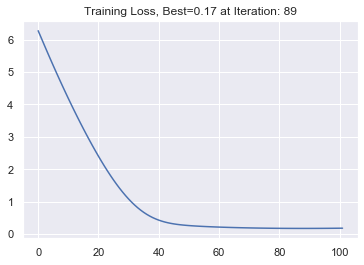

In [219]:
best_model.fit(X_train,y_train,lr=best_lr,bsize=best_bsize,gamma=best_gamma,beta=best_beta)

In [220]:
best_pred = best_model.predict(X_test)

In [222]:
print("Best Accuracy: {}".format(accuracy_score(y_test,best_pred)))

Best Accuracy: 0.9711036789297659


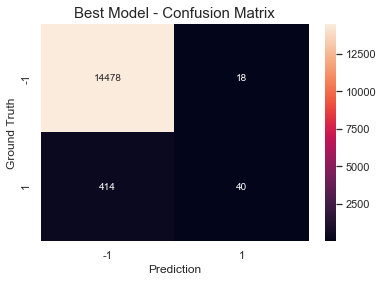

In [223]:
plt.figure(figsize=(6,4))
plt.title('Best Model - Confusion Matrix',fontsize=15)
sns.heatmap(confusion_matrix(y_test,best_pred), annot=True, fmt='d', cbar=True, xticklabels=[-1,1], yticklabels=[-1,1])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

Comparing to state of the art, sklearn results, our model is slighty less performing. It is quite difficult to interpret these results because the dataset is quite unbalanced. Indeed, our training dataset contains 48269 -1 values compared to only 1479 1 values. \
If this dataset corresponded to the results of medical tests, the prediction would be extremely unsatisfying. Indeed, model predicts 414 False Negatives for only 40 True Positives:
$$ Sensitivity=\frac{TruePositives}{TruePositives + FalseNegatives}=0.088 $$ \
This result is extremely low. As a matter of comparison, covid antigene tests have a sensitivity of 66-74% and PCR tests of 100%.